In [ ]:
import wandb
import os
import pandas as pd
import time
%matplotlib inline
import importlib
from common import common
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed

In [4]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [5]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/master/work/common/common.py'>

In [ ]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TOP_FEATURES_NUM = 5

In [110]:
# project name should correspond to dataset below
project_name = "thyroid"
# project_name = "cirrhosis"
# project_name = "heart"
# project_name = "hepatitis"

In [111]:
if project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "heart":
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()
else:
    %run datasets/hepatitis.ipynb
    all_df, main_labels, config = get_processed_hepatitis_df()

Normal class:  0    Benign
dtype: object
TARGET_DICT {0: 'Benign', 1: 'Botnet', 2: 'Bruteforce', 3: 'DDoS', 4: 'DoS', 5: 'Infiltration', 6: 'Portscan', 7: 'Webattack'}
NORMAL_TARGET 0
main_labels Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Fwd Packets Length Total', 'Bwd Packets Length Total',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'SYN Flag 

In [112]:
# Should already be one hot encoded and label encoded
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
0,51990738,3,1,43.0,6.0,31.0,14.333333,14.433757,6.0,6.00000,...,20,0.0,0.0,0.0,0.0,51940550.0,0.00,51940552.0,51940552.0,0
1,117384013,80,144,974.0,199741.0,275.0,12.175000,44.683636,1460.0,1387.09030,...,20,506187.0,628091.8,950315.0,62059.0,58155176.0,132745.16,58249039.0,58061309.0,0
2,246,2,2,64.0,204.0,32.0,32.000000,0.000000,102.0,102.00000,...,32,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
3,200929,13,11,1293.0,4610.0,694.0,99.461540,189.770750,1430.0,419.09090,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0
4,2446230,8,7,1144.0,1581.0,677.0,143.000000,227.969920,1173.0,225.85715,...,20,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0


In [113]:
all_df.shape

(2037240, 58)

In [114]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [115]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [116]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(1629792, 57) (407448, 57) (1629792,) (407448,)


In [117]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ClassLabel
1285014,3850770,14,8,1440.0,1731.0,725.0,102.857140,191.172840,1179.0,216.375,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1142876,4664549,5,4,935.0,790.0,935.0,187.000000,418.144700,395.0,197.500,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1229394,1301287,6,5,455.0,338.0,140.0,75.833336,62.936210,145.0,67.600,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
957100,60002992,2,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,...,0,0.0,0.0,0.0,0.0,60000000.0,0.0,60000000.0,60000000.0,0
1567448,5048320,3,1,12.0,2.0,6.0,4.000000,3.464102,2.0,2.000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)

In [119]:
X_test_scaled_df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
493261,-0.020415,-0.015738,-0.004453,-0.012115,-0.006301,0.764742,0.436446,0.624745,0.478884,0.067964,...,-0.015134,0.032096,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088
892391,-0.006094,-0.017676,-0.008706,-0.021371,-0.006688,0.326702,0.235001,0.629947,0.308839,0.113181,...,-0.017087,0.032096,-0.077826,-0.063697,-0.095915,-0.063886,-0.003148,-0.002339,-0.002144,-0.016888
1287921,-0.023986,-0.018645,-0.012959,-0.027550,-0.007306,-0.589382,-0.574314,-0.526563,-0.513469,-0.527766,...,-0.017576,0.032096,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088
1640422,-0.022599,-0.018161,-0.008706,-0.027281,-0.006693,-0.549378,-0.527192,-0.468247,0.302071,0.107906,...,-0.017087,0.032096,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088
862681,-0.024291,-0.018645,-0.011541,-0.026660,-0.007201,-0.523376,-0.341062,-0.526563,-0.443251,-0.308842,...,-0.017087,0.032095,-0.078654,-0.063697,-0.096529,-0.064852,-0.028091,-0.002339,-0.012429,-0.309088


In [ ]:
seconds = time.time()

minor_type_counts = all_df[TARGET_COLUMN].value_counts()
minor_type_dict = minor_type_counts.to_dict()
print('minor_type_dict', minor_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.get_dataset_for_label(label, name, target_index, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {0: 1597040, 3: 274283, 4: 87943, 1: 32390, 2: 23289, 5: 21107, 7: 686, 6: 502}
Botnet.csv created with 129560 rows. (97170 benign and 32390 abnormal rows)
Bruteforce.csv created with 93156 rows. (69867 benign and 23289 abnormal rows)
DDoS.csv created with 1097132 rows. (822849 benign and 274283 abnormal rows)
DoS.csv created with 351772 rows. (263829 benign and 87943 abnormal rows)
Infiltration.csv created with 84428 rows. (63321 benign and 21107 abnormal rows)
Portscan.csv created with 2008 rows. (1506 benign and 502 abnormal rows)
Webattack.csv created with 2744 rows. (2058 benign and 686 abnormal rows)
All datasets created successfully!
Total operation time: = 24.363980293273926 seconds


In [121]:
len(main_labels)

58

csv_files ['Portscan.csv', 'DDoS.csv', 'Botnet.csv', 'Bruteforce.csv', 'Webattack.csv', 'DoS.csv', 'Infiltration.csv']
Processing CSV file: Portscan.csv
Portscan importance list:
Portscan 
                           importance
Features                            
Bwd Packet Length Max       0.047844
Bwd Packets Length Total    0.045976
Bwd Packet Length Mean      0.037048
Flow IAT Min                0.029921
Fwd Packets Length Total    0.029497
Flow Duration               0.028003
Fwd Packet Length Mean      0.025561
Flow Bytes/s                0.022621
Flow IAT Mean               0.020140
Flow Packets/s              0.018358
Flow IAT Max                0.018129
Fwd IAT Mean                0.013208
Fwd IAT Std                 0.010405
Fwd Packet Length Max       0.009827
Fwd IAT Total               0.007843
Total Backward Packets      0.007263
Total Fwd Packets           0.007224
Fwd Packet Length Std       0.007041
Flow IAT Std                0.006444
Bwd Packet Length Std       0.006

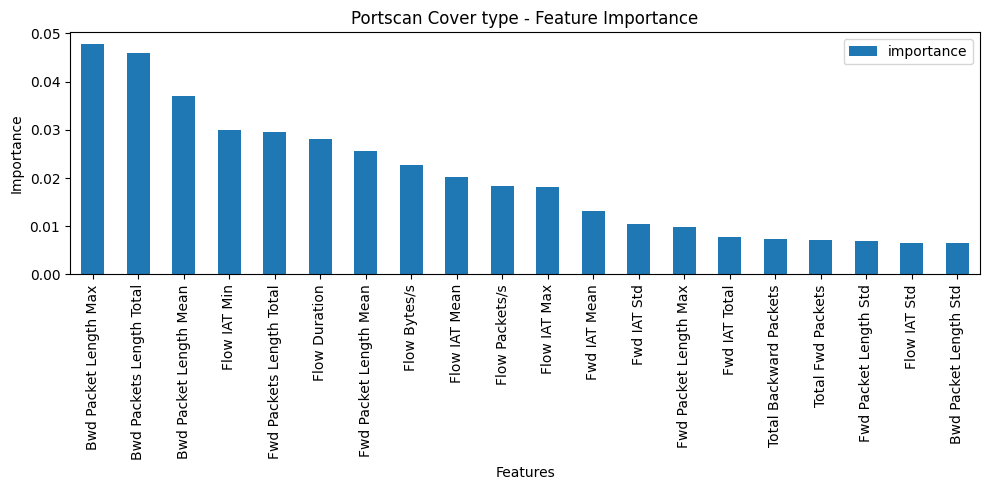

-----------------------------------------------------------------------------------------------




Processing CSV file: DDoS.csv
DDoS importance list:
DDoS 
                           importance
Features                            
Fwd Packets Length Total    0.055479
Fwd Packet Length Mean      0.045295
Total Backward Packets      0.041153
Fwd Packet Length Max       0.035727
Bwd Packet Length Std       0.034781
Fwd IAT Total               0.030475
Bwd Packet Length Mean      0.027318
Bwd Packet Length Max       0.022774
Fwd IAT Mean                0.020193
Flow IAT Max                0.017713
Flow IAT Mean               0.017526
Flow Duration               0.017014
Flow Packets/s              0.016549
Total Fwd Packets           0.015467
Bwd Packets Length Total    0.012262
Flow IAT Min                0.011069
Fwd Packet Length Std       0.006762
Flow Bytes/s                0.005323
Flow IAT Std                0.003122
Fwd IAT Std                 0.002550 



DDoS=["Fwd Packets Leng

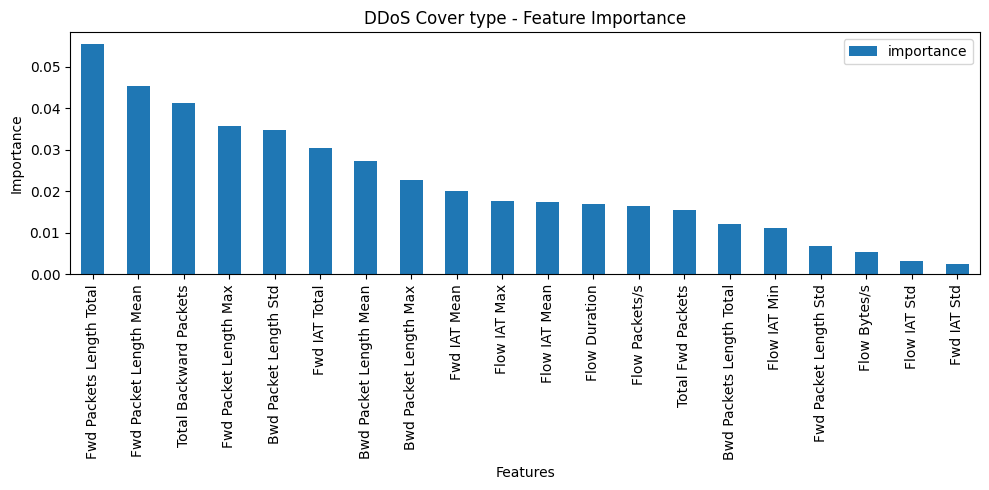

-----------------------------------------------------------------------------------------------




Processing CSV file: Botnet.csv
Botnet importance list:
Botnet 
                           importance
Features                            
Flow Duration               0.063014
Fwd Packet Length Mean      0.058800
Flow Packets/s              0.055309
Flow IAT Std                0.042113
Bwd Packet Length Mean      0.042056
Flow IAT Max                0.033765
Flow Bytes/s                0.031503
Bwd Packet Length Std       0.031022
Fwd Packet Length Max       0.029355
Flow IAT Mean               0.025254
Bwd Packets Length Total    0.023768
Fwd Packet Length Std       0.022887
Bwd Packet Length Max       0.019134
Fwd Packets Length Total    0.016225
Total Backward Packets      0.015718
Fwd IAT Std                 0.007005
Fwd IAT Total               0.006589
Fwd IAT Mean                0.005679
Flow IAT Min                0.001210
Total Fwd Packets           0.000929 



Botnet=["Flow Dur

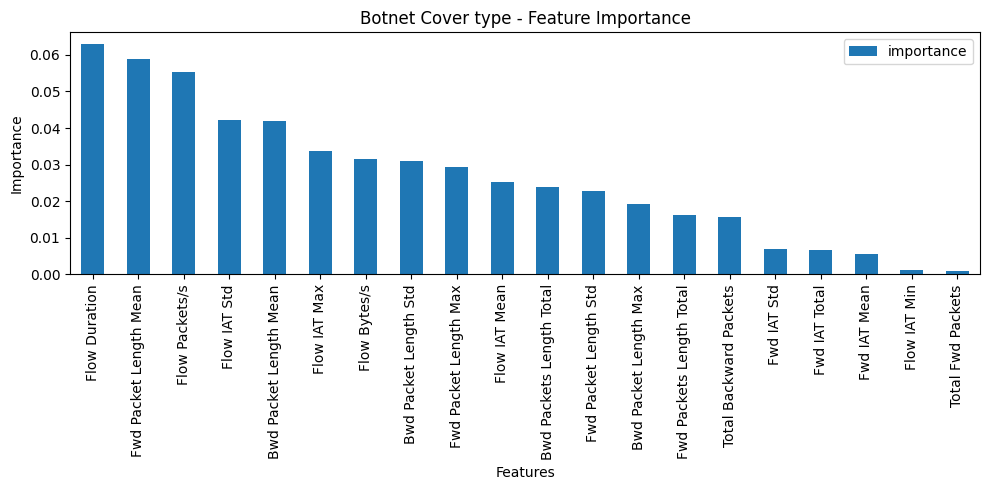

-----------------------------------------------------------------------------------------------




Processing CSV file: Bruteforce.csv
Bruteforce importance list:
Bruteforce 
                           importance
Features                            
Fwd Packets Length Total    0.102546
Total Backward Packets      0.071977
Bwd Packet Length Max       0.049467
Total Fwd Packets           0.031933
Bwd Packets Length Total    0.010091
Bwd Packet Length Mean      0.009971
Flow Packets/s              0.006944
Flow IAT Mean               0.005967
Fwd Packet Length Mean      0.004281
Bwd Packet Length Std       0.004267
Fwd IAT Mean                0.003873
Fwd Packet Length Max       0.003625
Fwd Packet Length Std       0.003364
Flow IAT Max                0.002687
Flow Duration               0.001534
Flow Bytes/s                0.001195
Fwd IAT Std                 0.000898
Fwd IAT Total               0.000502
Flow IAT Std                0.000395
Flow IAT Min                0.000242 



Brute

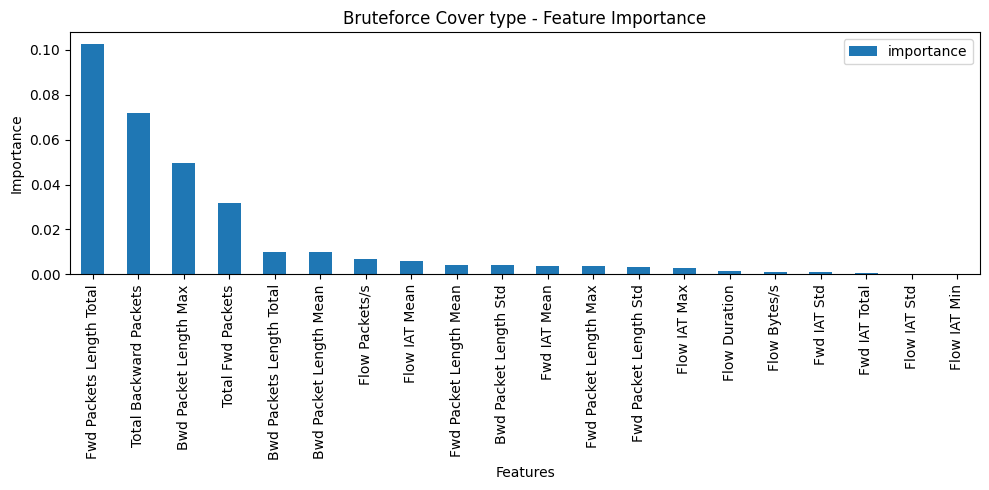

-----------------------------------------------------------------------------------------------




Processing CSV file: Webattack.csv
Webattack importance list:
Webattack 
                           importance
Features                            
Fwd Packet Length Mean      0.043162
Flow Duration               0.039038
Fwd Packets Length Total    0.038093
Fwd IAT Std                 0.034411
Flow Bytes/s                0.031107
Flow IAT Max                0.026758
Flow IAT Std                0.025810
Flow IAT Mean               0.023449
Flow Packets/s              0.022129
Total Fwd Packets           0.020162
Fwd Packet Length Max       0.019561
Fwd IAT Mean                0.017816
Bwd Packet Length Max       0.014964
Fwd IAT Total               0.013254
Flow IAT Min                0.012952
Total Backward Packets      0.009837
Bwd Packet Length Std       0.006834
Bwd Packet Length Mean      0.006361
Fwd Packet Length Std       0.005710
Bwd Packets Length Total    0.004195 



Webattac

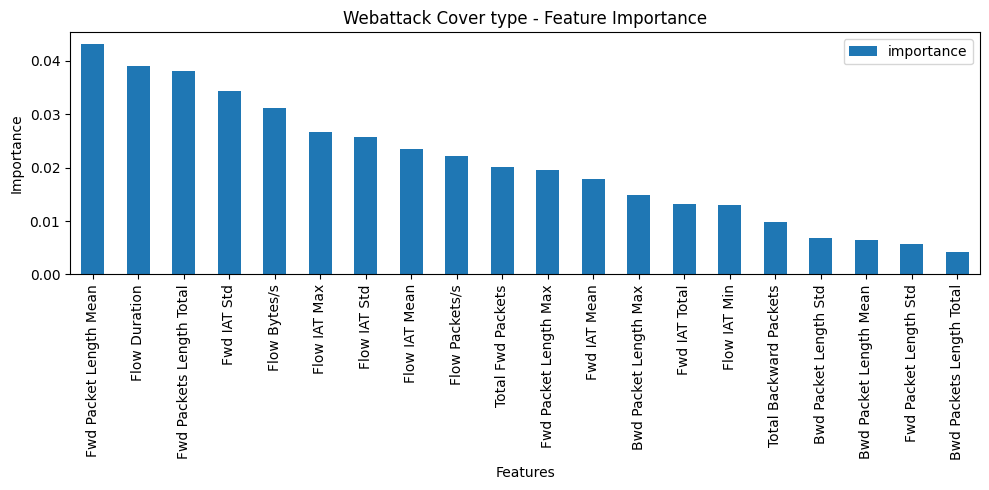

-----------------------------------------------------------------------------------------------




Processing CSV file: DoS.csv
DoS importance list:
DoS 
                           importance
Features                            
Bwd Packet Length Max       0.049149
Bwd Packet Length Std       0.044761
Bwd Packet Length Mean      0.022748
Bwd Packets Length Total    0.021272
Total Backward Packets      0.019537
Flow Bytes/s                0.014436
Fwd Packet Length Max       0.014025
Flow IAT Min                0.014025
Fwd IAT Mean                0.013646
Flow Packets/s              0.013244
Flow IAT Std                0.012255
Fwd IAT Std                 0.011817
Fwd IAT Total               0.010797
Fwd Packets Length Total    0.010743
Flow IAT Mean               0.009172
Flow IAT Max                0.008981
Flow Duration               0.006876
Fwd Packet Length Mean      0.006519
Fwd Packet Length Std       0.005609
Total Fwd Packets           0.005460 



DoS=["Bwd Packet Length Ma

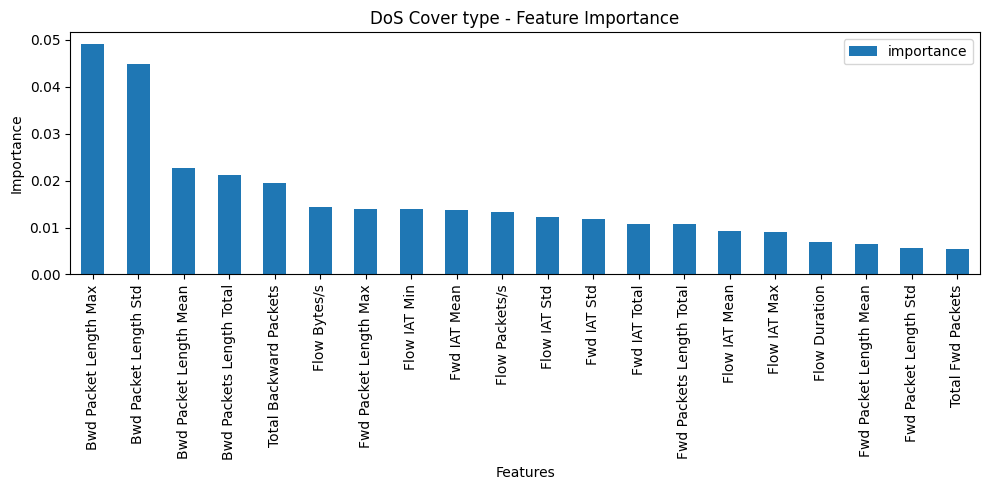

-----------------------------------------------------------------------------------------------




Processing CSV file: Infiltration.csv
Infiltration importance list:
Infiltration 
                           importance
Features                            
Flow IAT Min                0.054209
Flow IAT Max                0.043194
Flow IAT Mean               0.037660
Flow Duration               0.037549
Flow Packets/s              0.036280
Flow Bytes/s                0.033837
Fwd IAT Mean                0.028161
Fwd IAT Total               0.027977
Flow IAT Std                0.021849
Fwd Packet Length Mean      0.019243
Fwd IAT Std                 0.018400
Fwd Packet Length Max       0.017766
Fwd Packet Length Std       0.015334
Fwd Packets Length Total    0.015036
Bwd Packet Length Max       0.014917
Bwd Packets Length Total    0.014812
Bwd Packet Length Mean      0.013929
Bwd Packet Length Std       0.007514
Total Fwd Packets           0.005831
Total Backward Packets      0.005432 




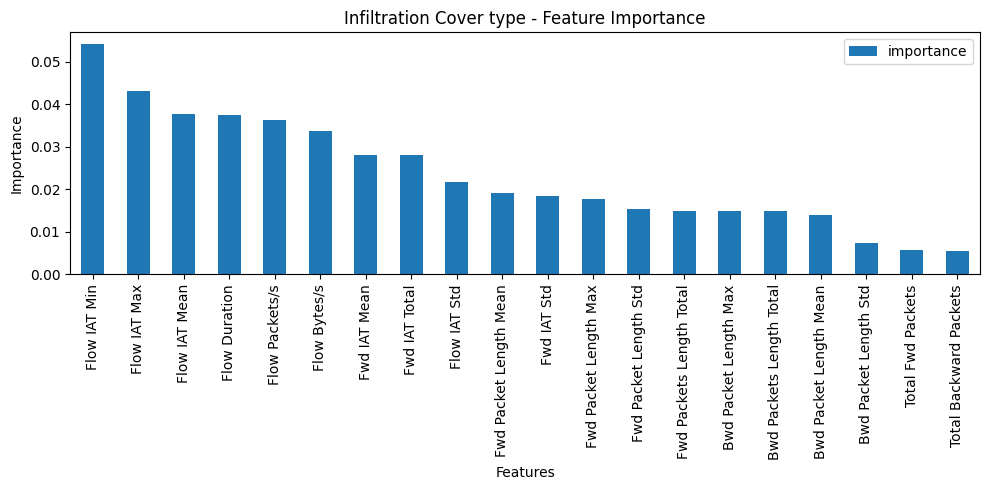

-----------------------------------------------------------------------------------------------




feature_importances: {'Portscan': ['Bwd Packet Length Max', 'Bwd Packets Length Total', 'Bwd Packet Length Mean', 'Flow IAT Min', 'Fwd Packets Length Total'], 'DDoS': ['Fwd Packets Length Total', 'Fwd Packet Length Mean', 'Total Backward Packets', 'Fwd Packet Length Max', 'Bwd Packet Length Std'], 'Botnet': ['Flow Duration', 'Fwd Packet Length Mean', 'Flow Packets/s', 'Flow IAT Std', 'Bwd Packet Length Mean'], 'Bruteforce': ['Fwd Packets Length Total', 'Total Backward Packets', 'Bwd Packet Length Max', 'Total Fwd Packets', 'Bwd Packets Length Total'], 'Webattack': ['Fwd Packet Length Mean', 'Flow Duration', 'Fwd Packets Length Total', 'Fwd IAT Std', 'Flow Bytes/s'], 'DoS': ['Bwd Packet Length Max', 'Bwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packets Length Total', 'Total Backward Packets'], 'Infiltration': ['Flow IAT Min', 'Flow IAT Max', 'Flow IAT Mean', 'Flow Duration', 'Fl

In [ ]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}
modelname = "knn"

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        top_features_num=TOP_FEATURES_NUM,
        scaler=scaler,
        modelname=modelname)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [123]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [0 4 0 ... 0 0 3]
Total operation time: =  109.1389856338501 seconds


Multiclass Classification Evaluation


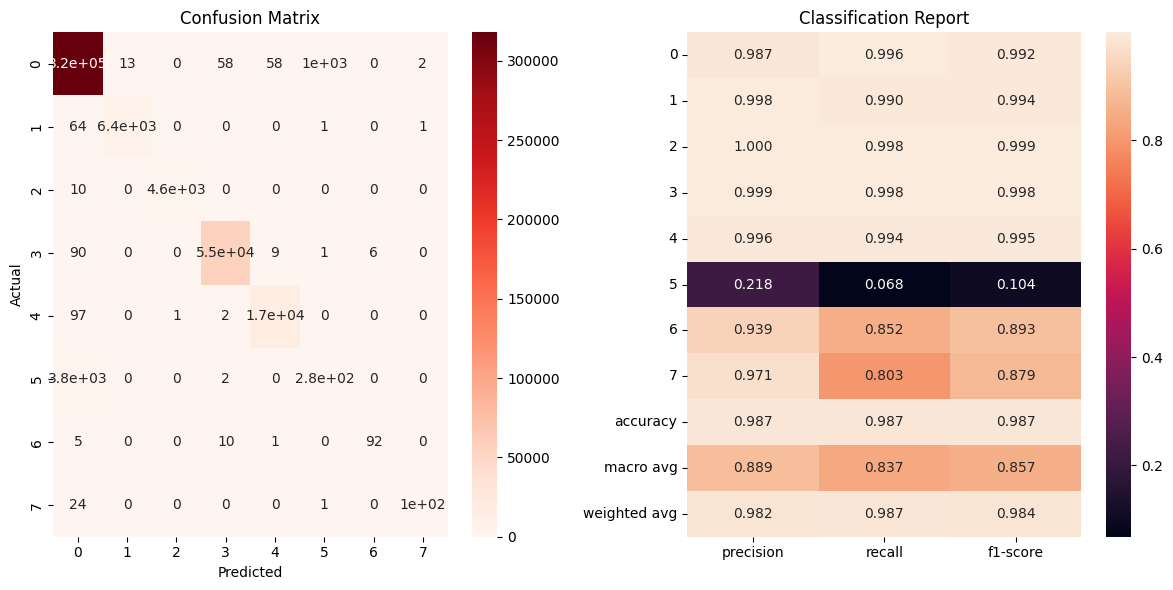

Accuracy: 0.9869946594412048


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.98699
f1-score_avg,0.9839
precision_avg,0.98164
recall_avg,0.98699


In [124]:
pn = "final-pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [ ]:
seconds = time.time()
CONF_THRESHOLD = 0.95

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict(test_instance_selected_df)
    # print(knn_prediction)
    major_class_prob = knn_prediction[:, 1]
    minor_class_prob = knn_prediction[:, 0]
    
    return (minor_class_prob, major_class_prob)
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        max_prob = CONF_THRESHOLD
        final_class_1 = NORMAL_TARGET
        final_class_2 = final_class_1

        for key, knn in KNNs.items():
            sub_minor_class_prob, sub_major_class_prob = predict_knn(key, test_instance_df)
            if sub_minor_class_prob > sub_major_class_prob and sub_minor_class_prob > max_prob:
                max_prob = sub_minor_class_prob
                final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'NORMAL improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'NORMAL deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        minor_class_prob, major_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = minor_class_prob if minor_class_prob > major_class_prob else major_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if minor_class_prob > major_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if major_class_prob > 1.0 - CONF_THRESHOLD and major_class_prob < CONF_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_minor_class_prob, sub_major_class_prob = predict_knn(key, test_instance_df)
                    if sub_minor_class_prob > sub_major_class_prob and sub_minor_class_prob > max_prob:
                        max_prob = sub_minor_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, major_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, major_class_prob, max_prob)

    return i, final_class_2

# Run all test data instances in parallel and retain order
knn_predictions = [None] * len(X_test_scaled_df) 

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        knn_predictions[idx] = prediction 

print("Total operation time: = ", time.time() - seconds, "seconds")

Total operation time: =  316.3986105918884 seconds


KNN Evaluation (overall)


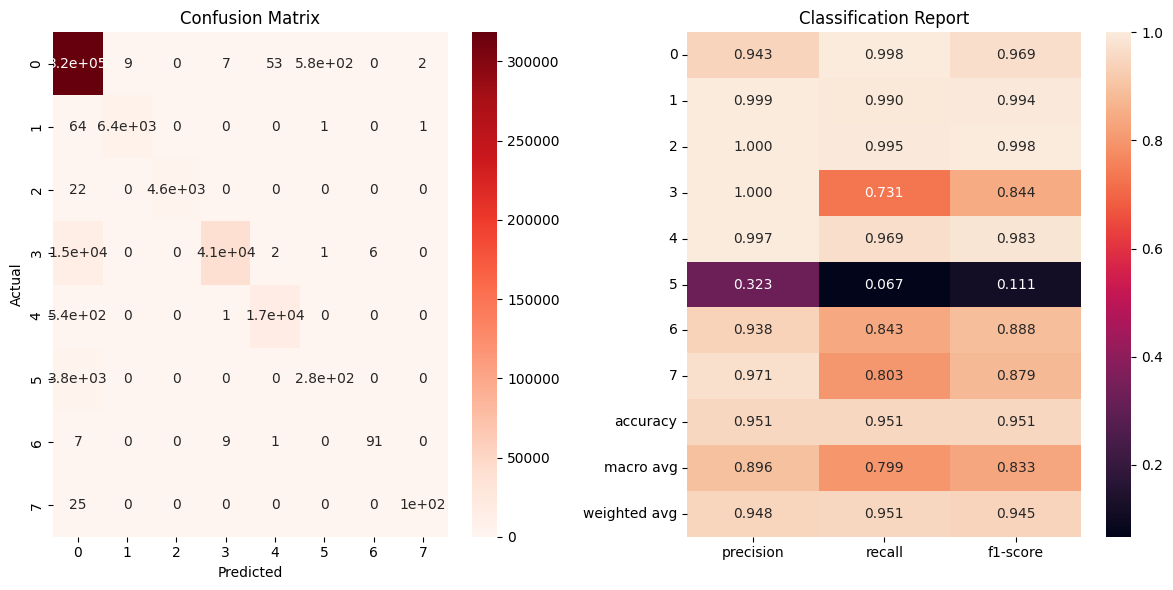

Accuracy: 0.950698003180774


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.9507
f1-score_avg,0.94497
precision_avg,0.94789
recall_avg,0.9507


In [126]:
# Evaluate KNN on all test data
pn = "final-pipeline-" + project_name
wandb.init(project=pn, name="final")

final_knn_predictions_df = pd.DataFrame(knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()